# West Coast Swing Playlist Analytics

Stemming from a one of the fantastic talks at [Westie Wisdom](https://www.super-secret-moves.com/workshops/fuer-trainer-und-organizer) where Flo G. detailed how he went about analyzing his sets using [Spotify's various metrics](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) provided for songs. This is an attempt at continuing down that analytic path to answer some questions:

* **What do various WCS DJ playlists/sets look like?** (from the good to the bad - focusing mainly on the ordered playlists)
* **What music is (un)common in my bubble?** (get spotify connections and map their playlists)

## What do various WCS DJ playlists/sets look like?

### Tools
* Playlist analyzer: https://www.chosic.com/spotify-playlist-analyzer/
* BPM tool: https://www.all8.com/tools/bpm.htm
* Ale≈°' Event/DJ Playlist Tracker: http://klopca.com/dance/west-coast-swing/music/2024events

I pasted the spotify playlist links into the [playlist analyzer](https://www.chosic.com/spotify-playlist-analyzer/), and downloaded the `.csv` at the bottom

### Graphs! 
(üòî Have to use Matplotlib for Github viewing)

A beginner DJ made some playlists that were too fast (first 3 graphs), but you can see that on the 3rd, with guidance, the set improved around halfway through. Mistakes are great, because you get to improve, and it gives us examples to work with!

The subsequent graphs are sets during events from established DJ's, and you can see the slow pulses and/or gradual slowing of BPM.

`Note:`
*If you a really high or low spike that doesn't match the surrounding bpm's, it's likely because Spotify doesn't always get it right. I've tried to correct the worst ones, but there will still be some that escape.*

/opt/anaconda3/envs/py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


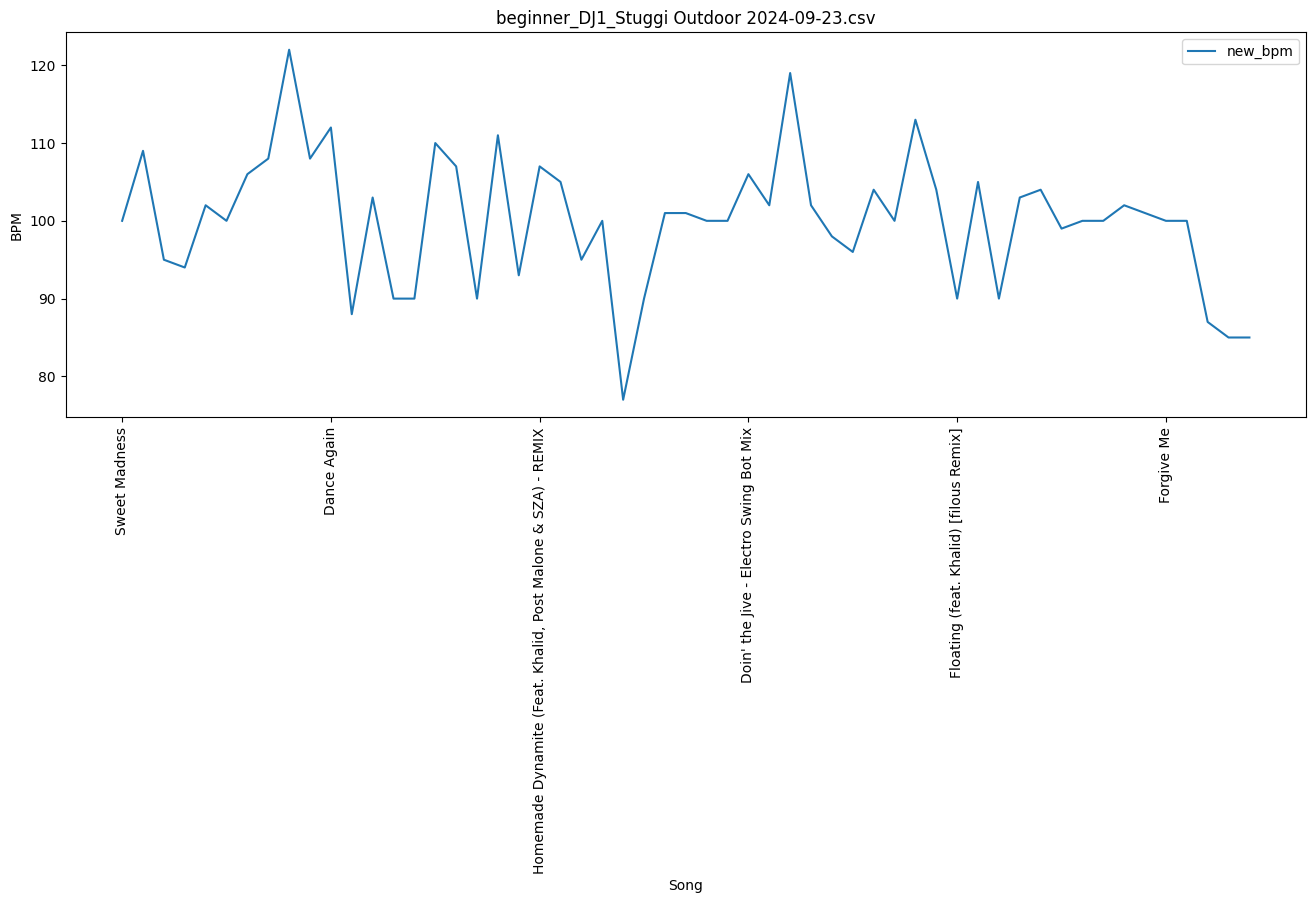

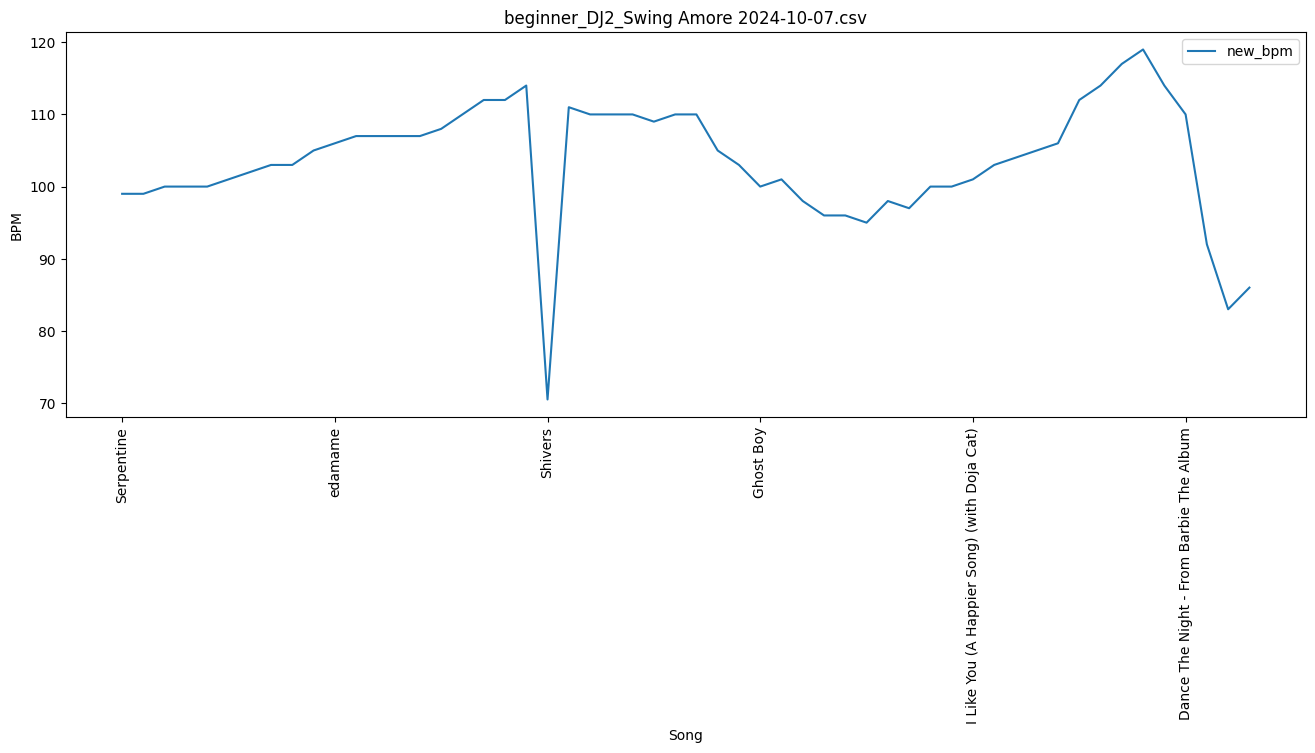

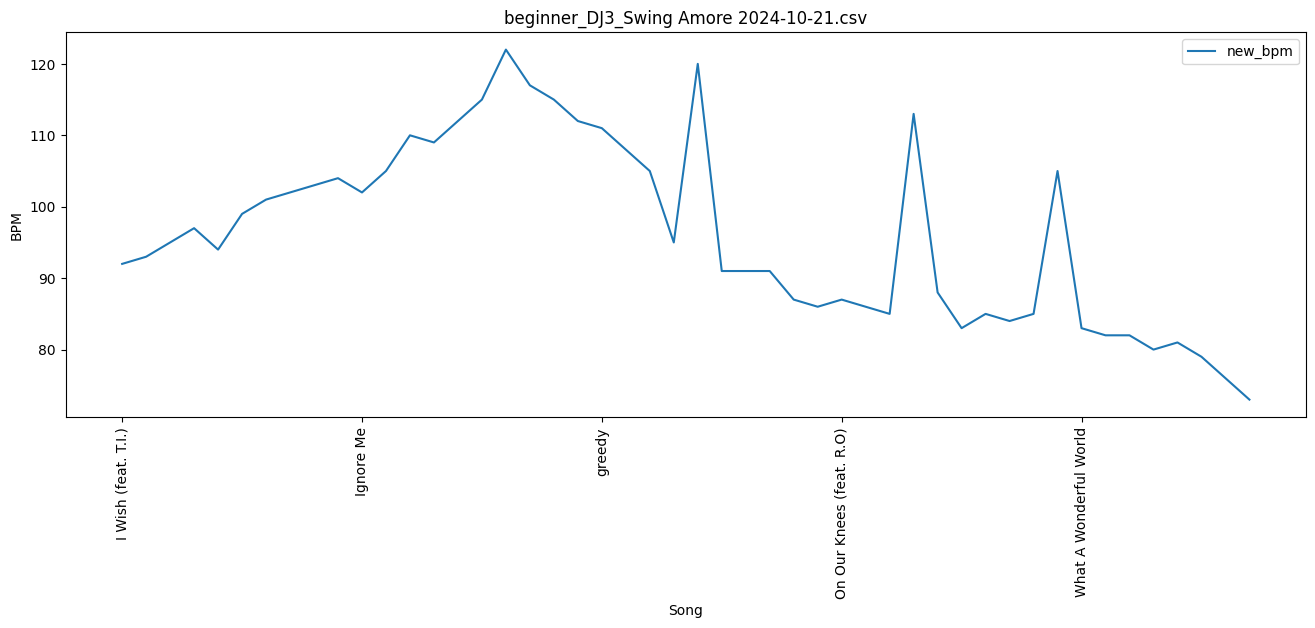

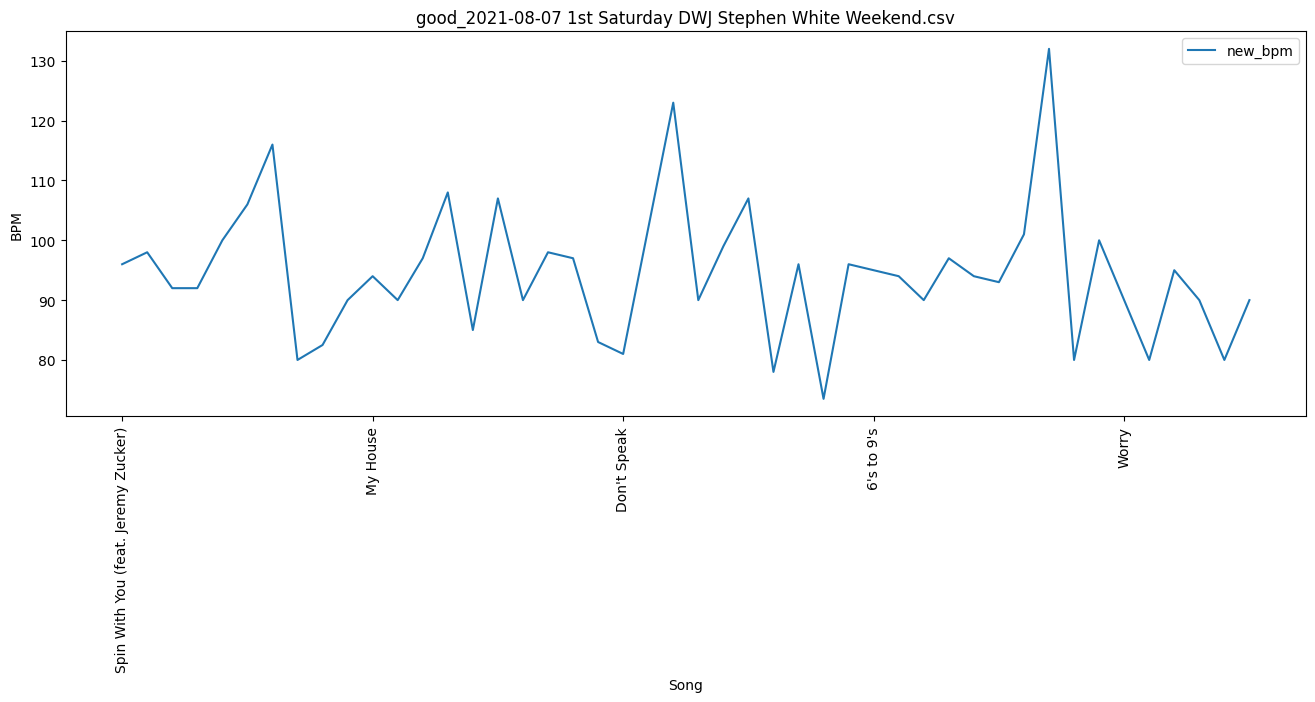

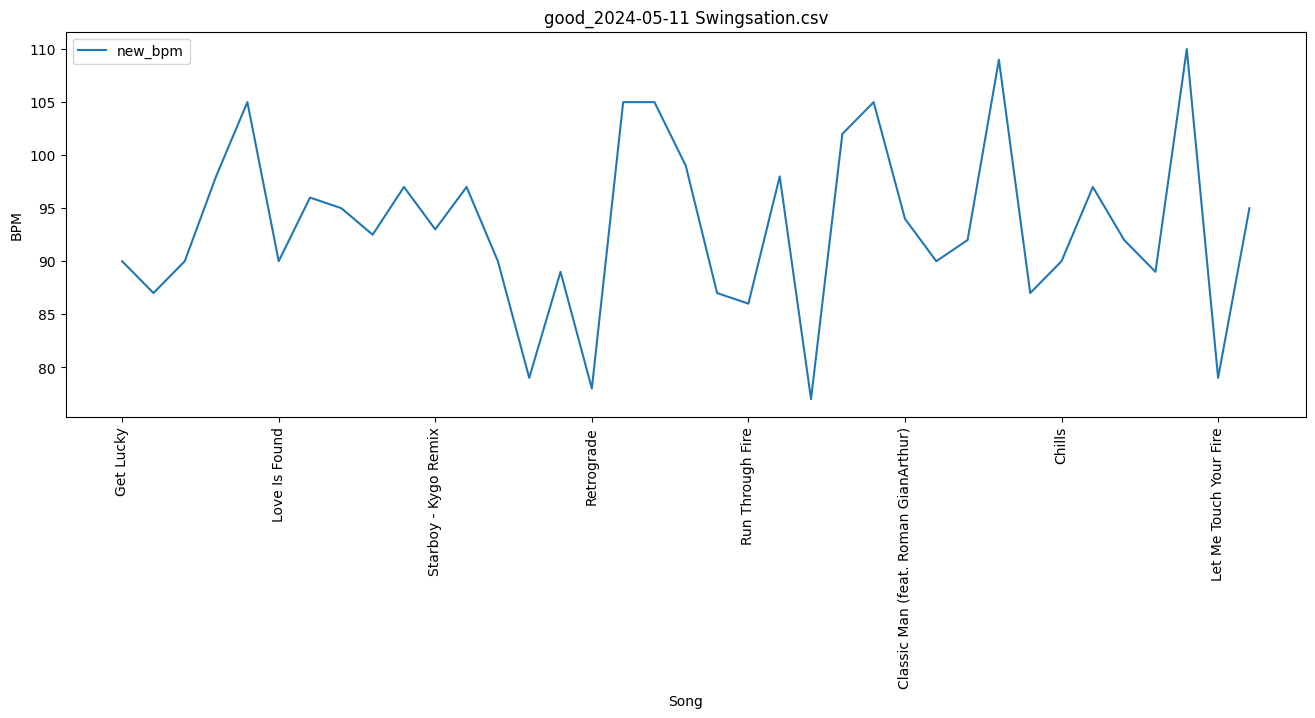

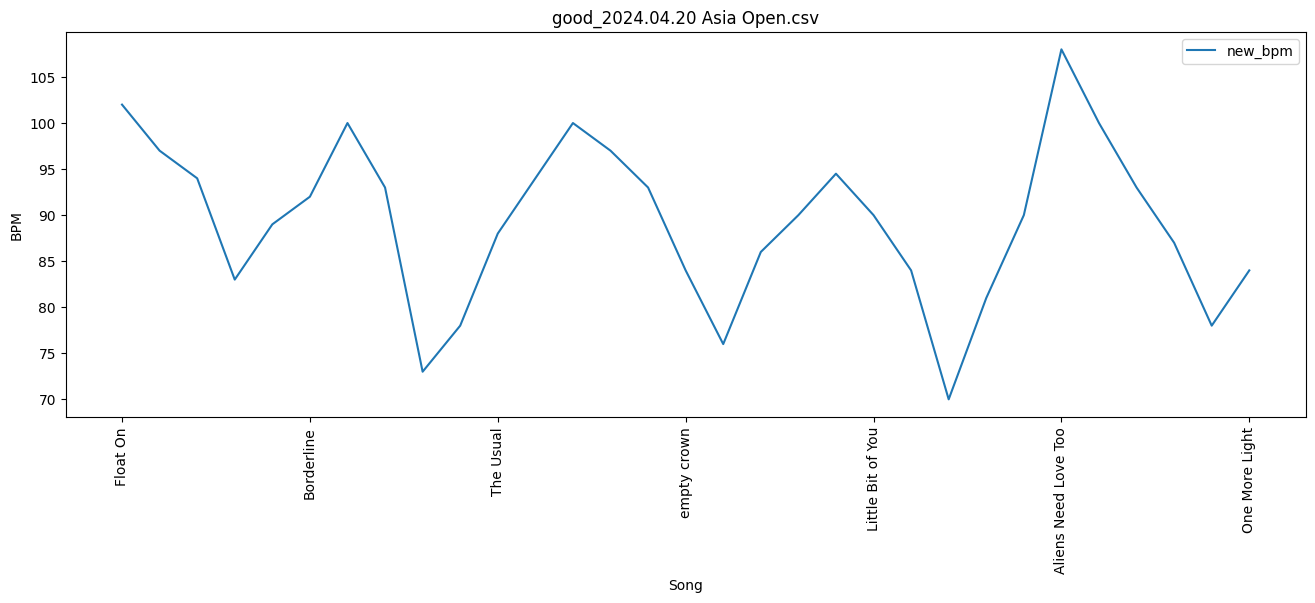

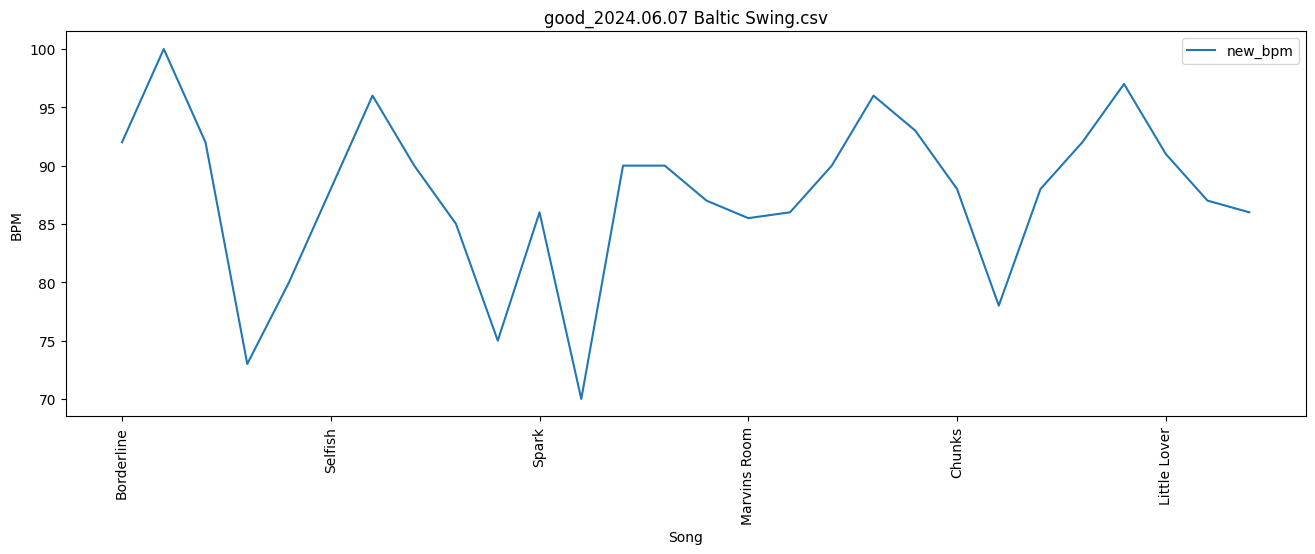

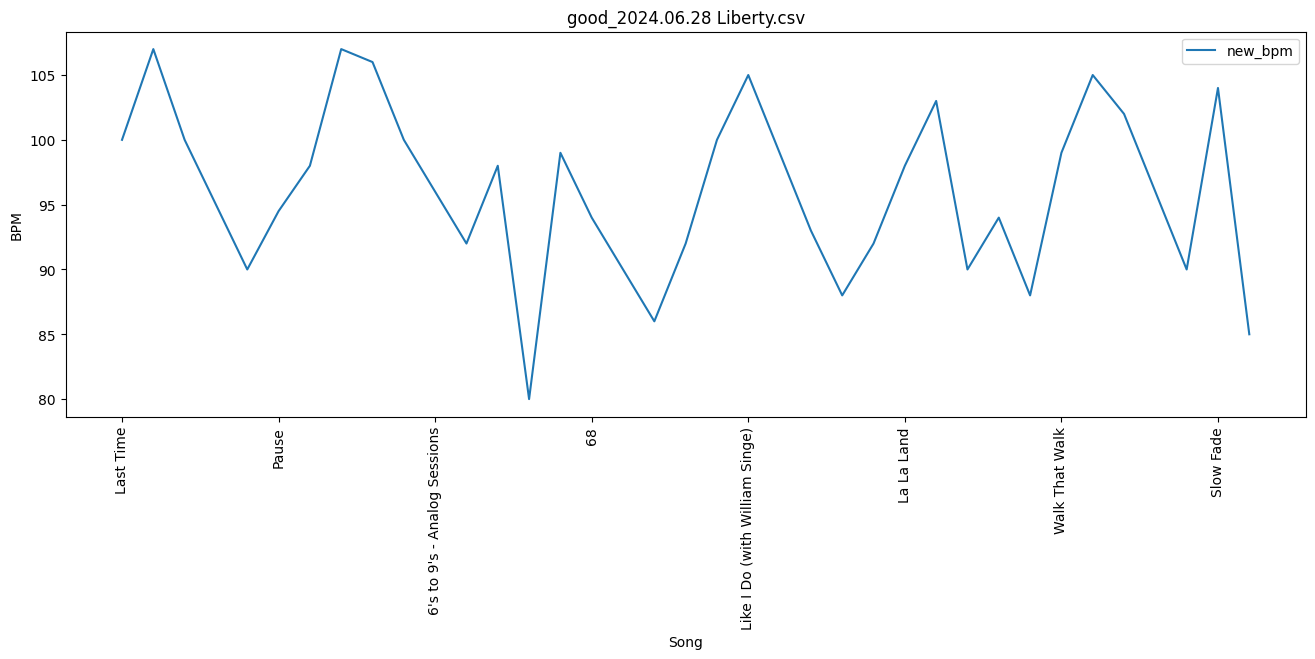

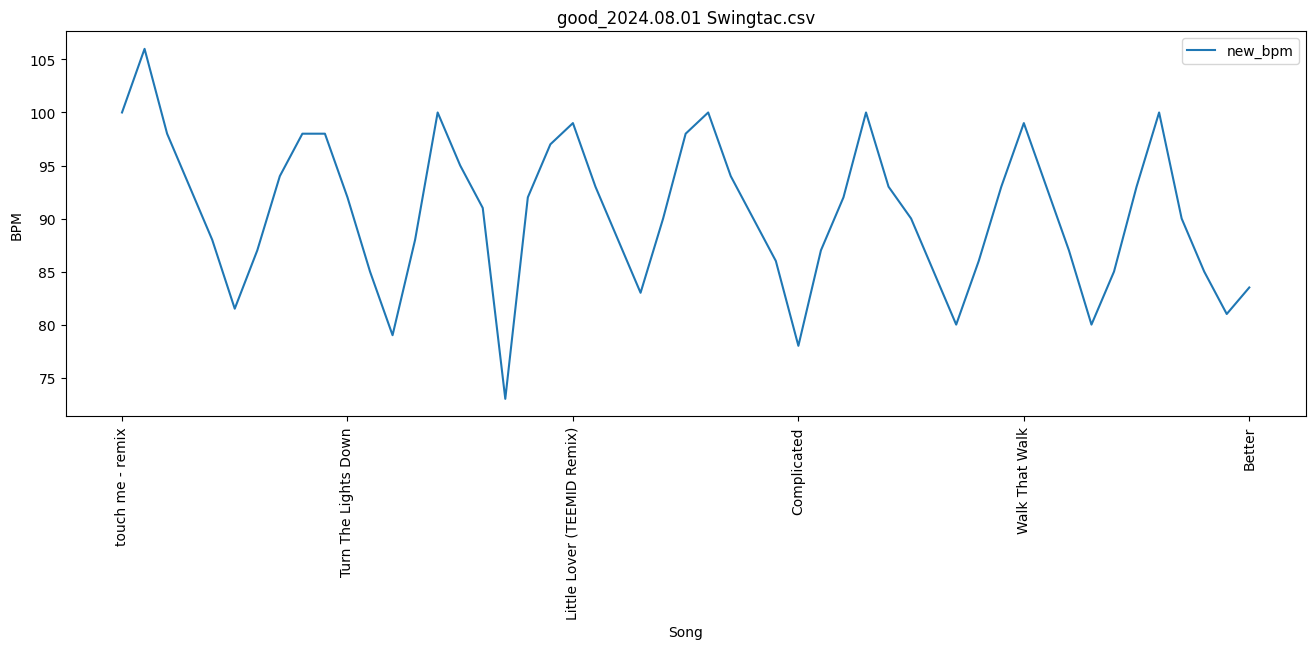

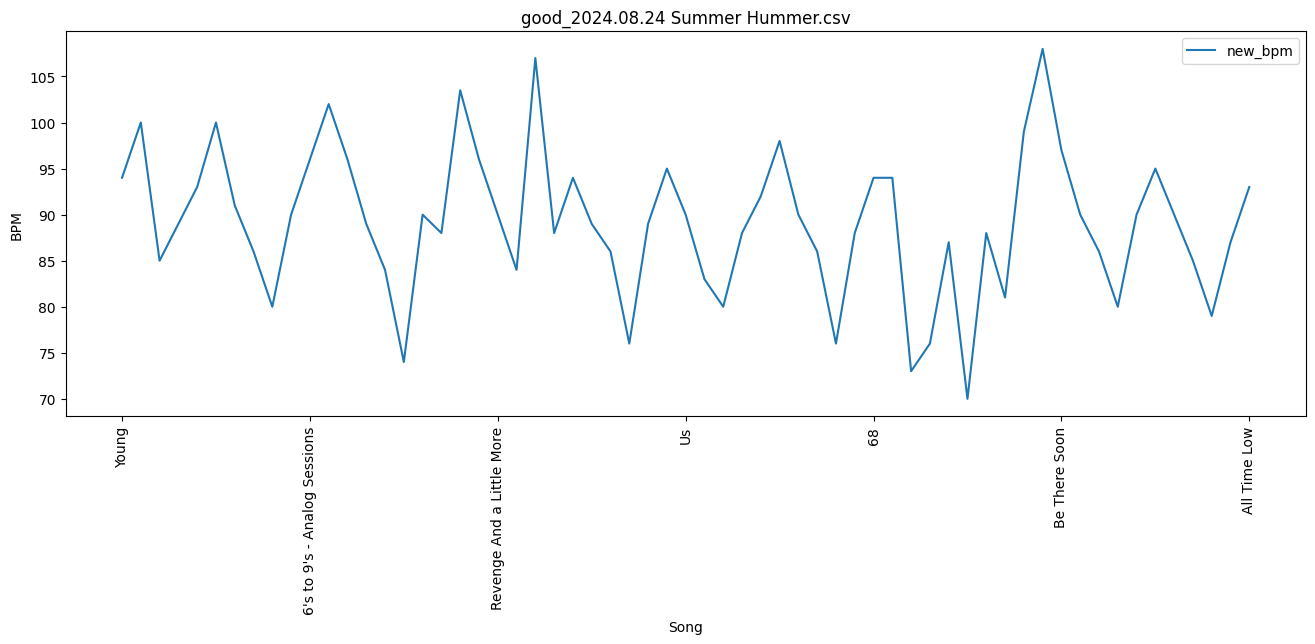

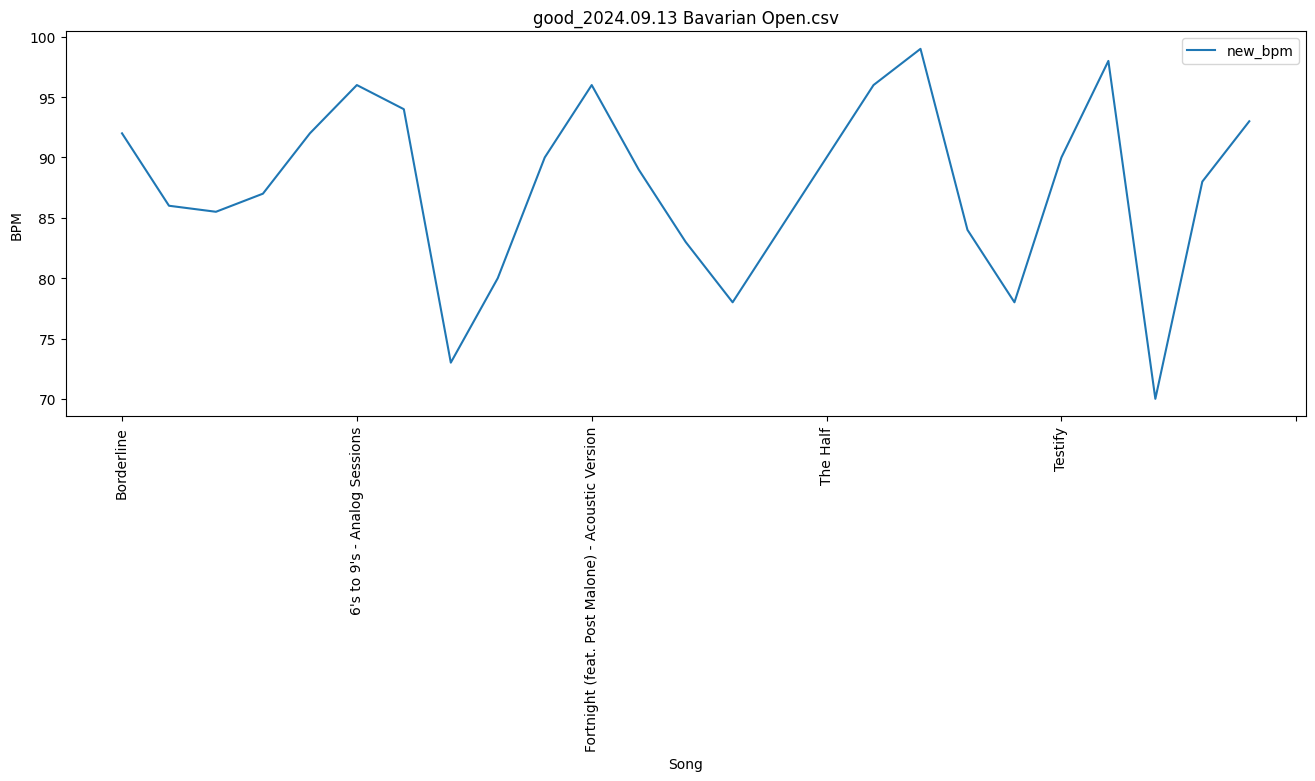

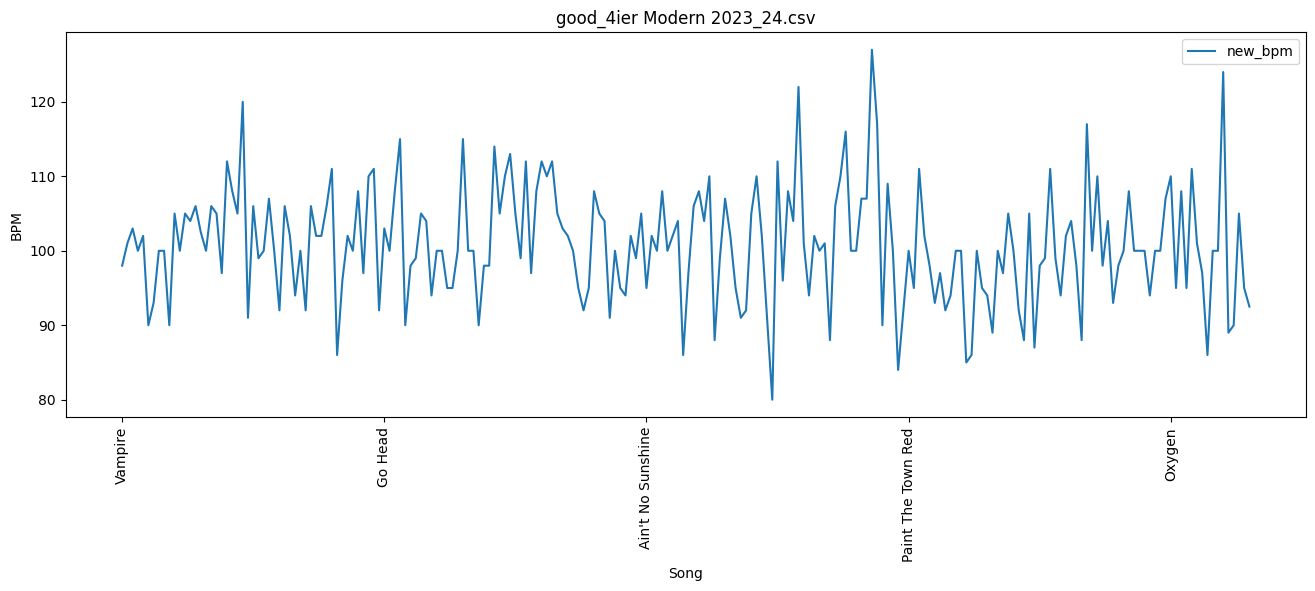

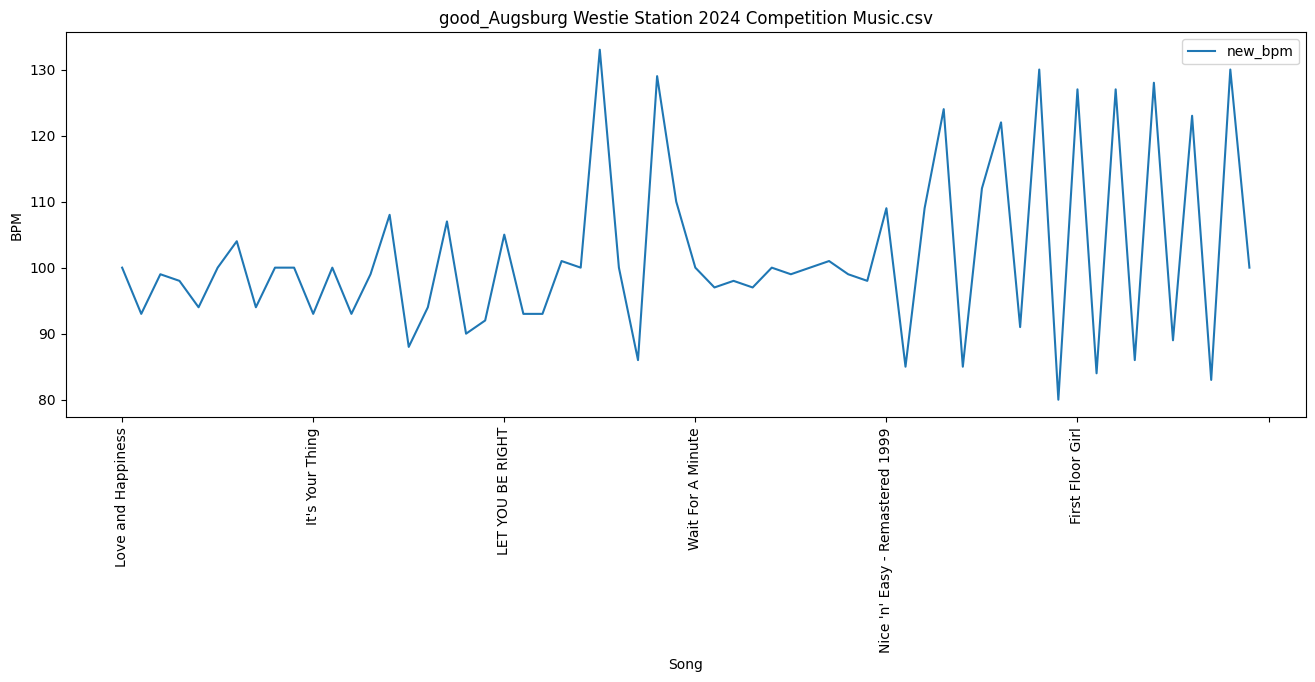

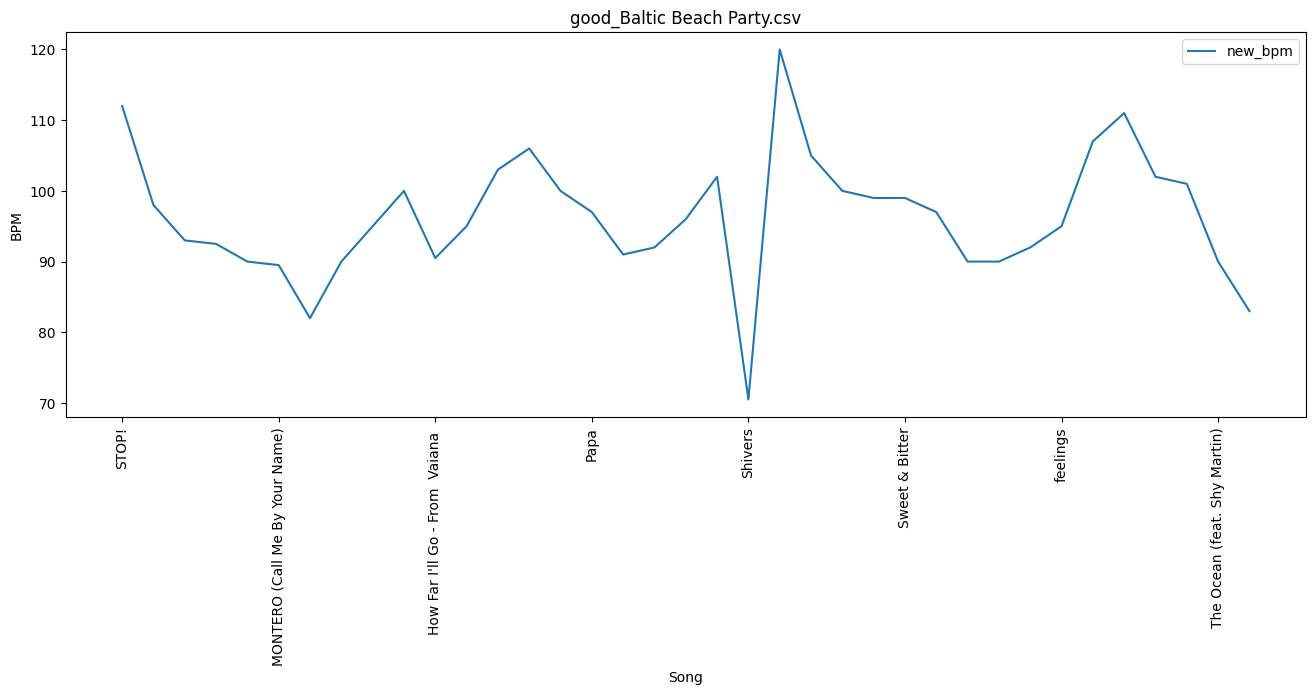

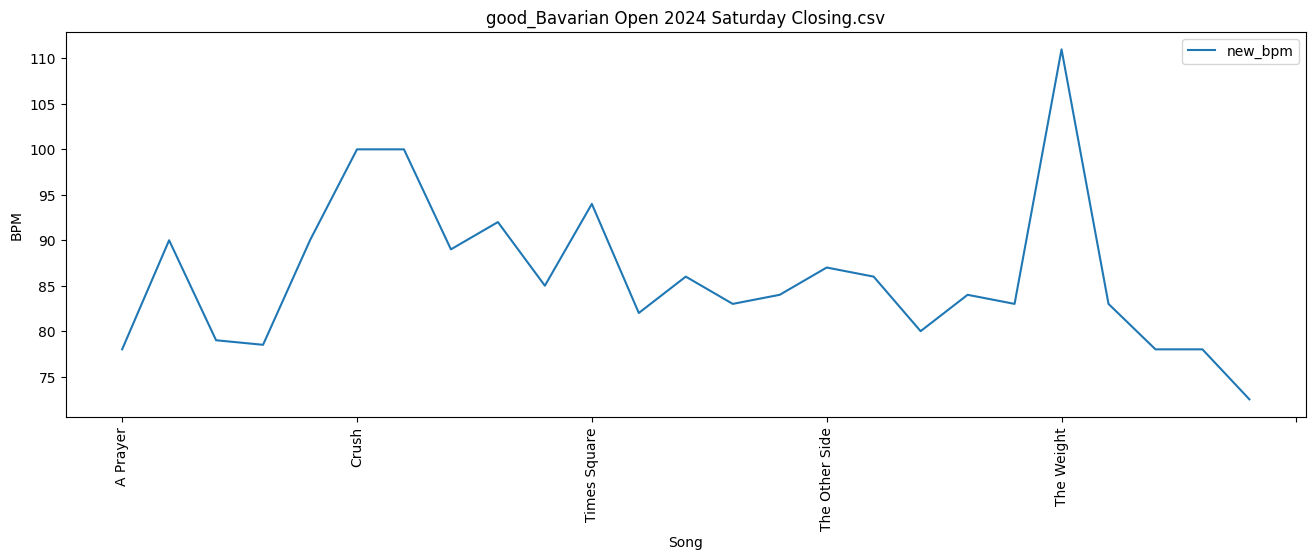

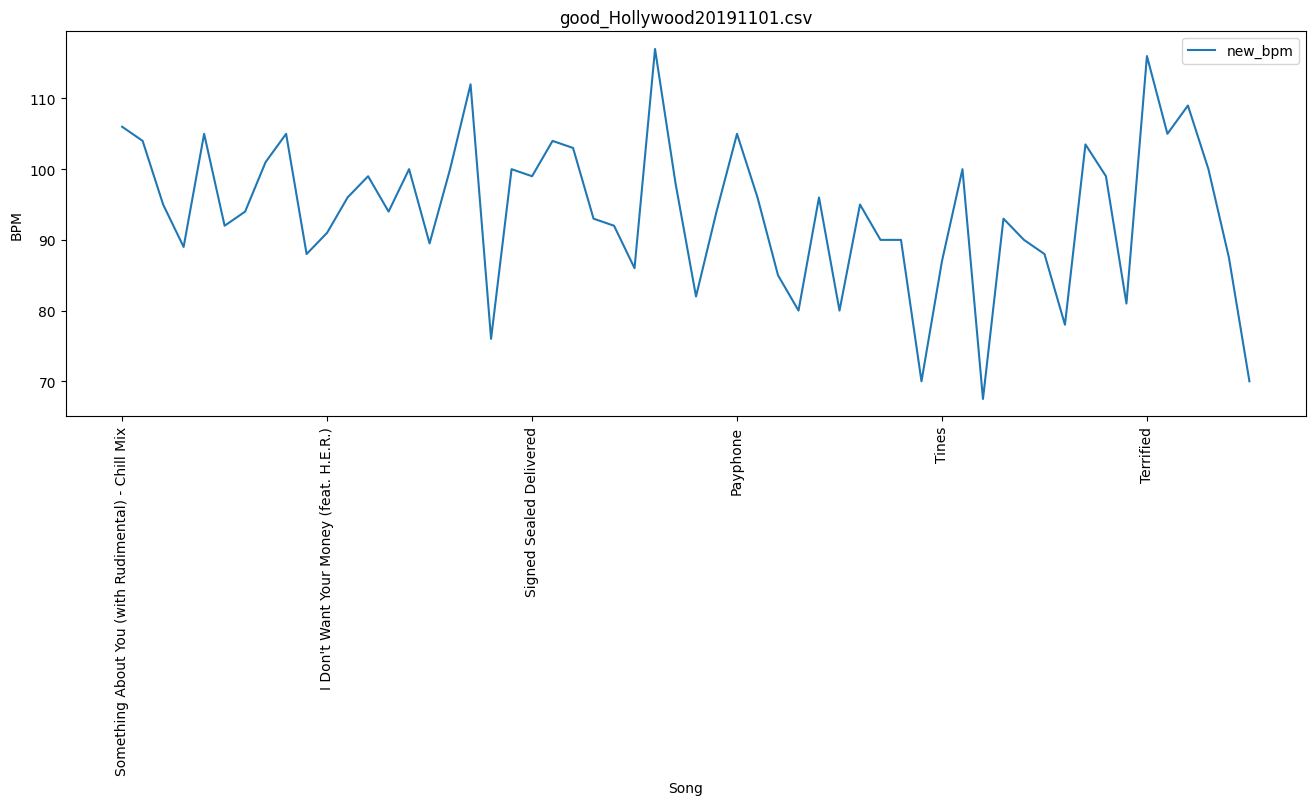

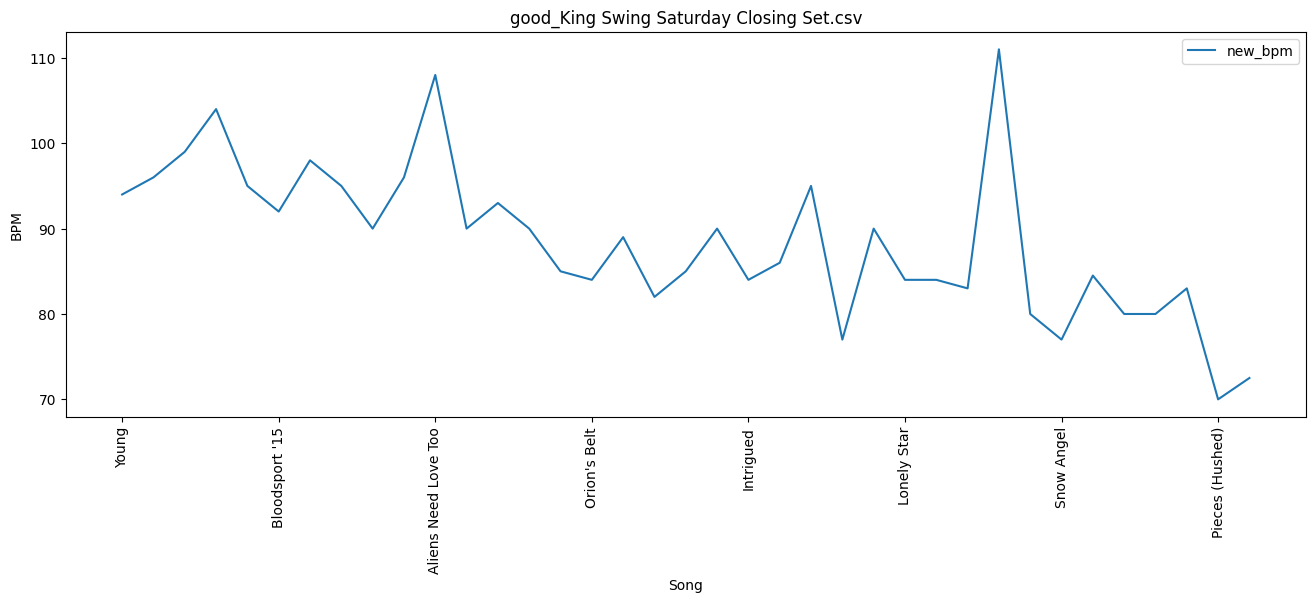

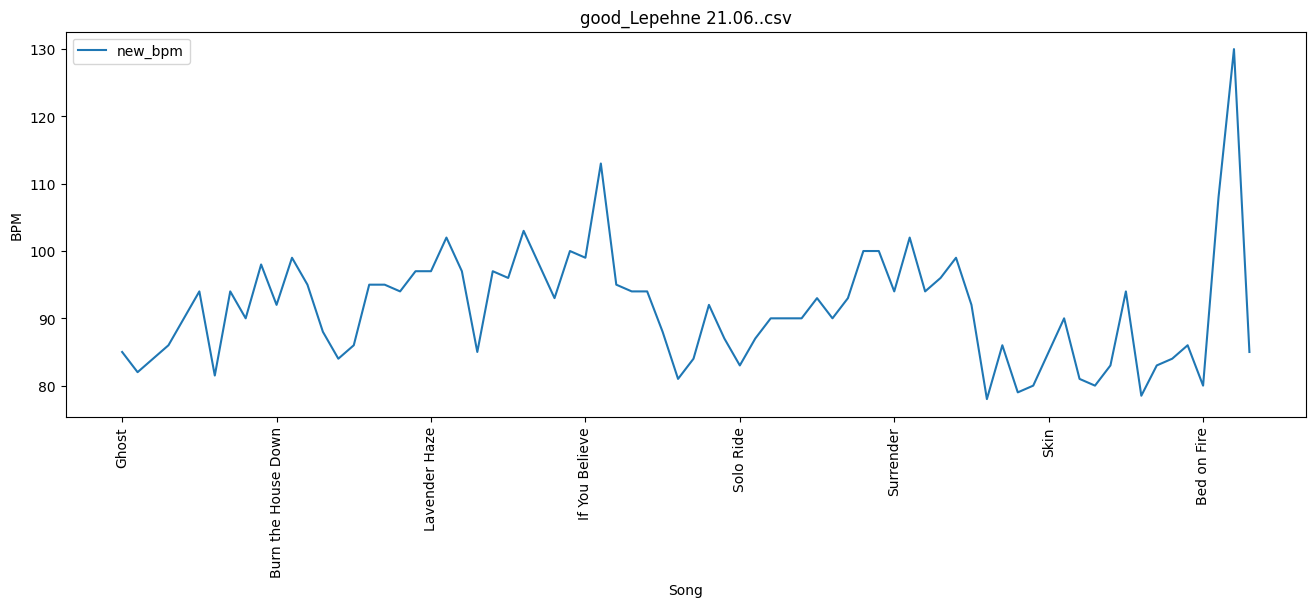

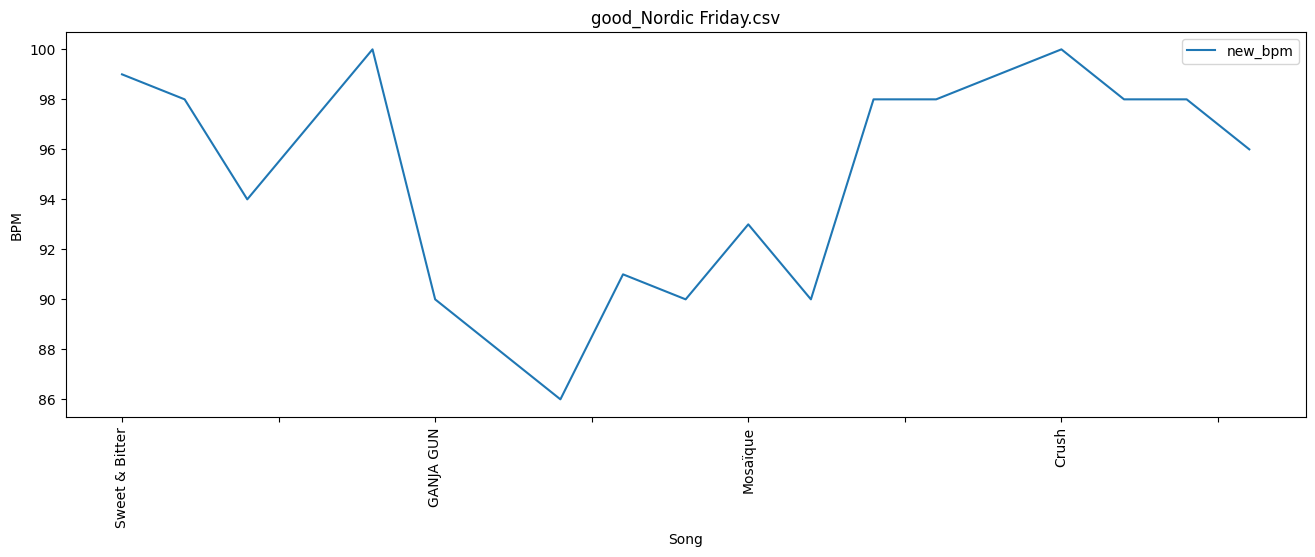

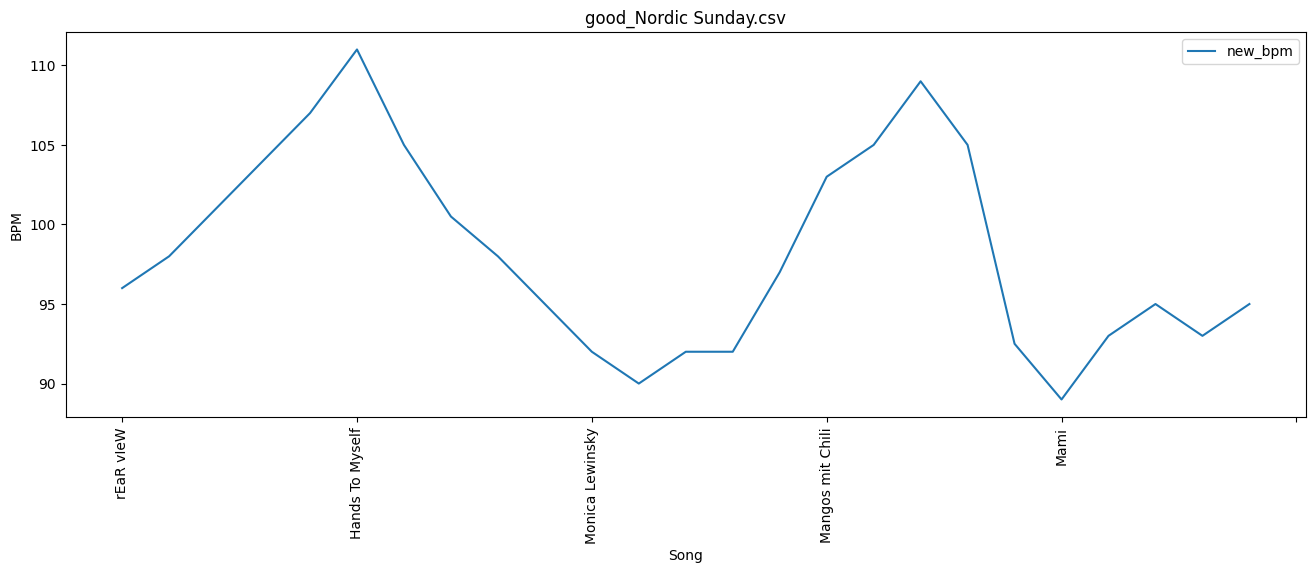

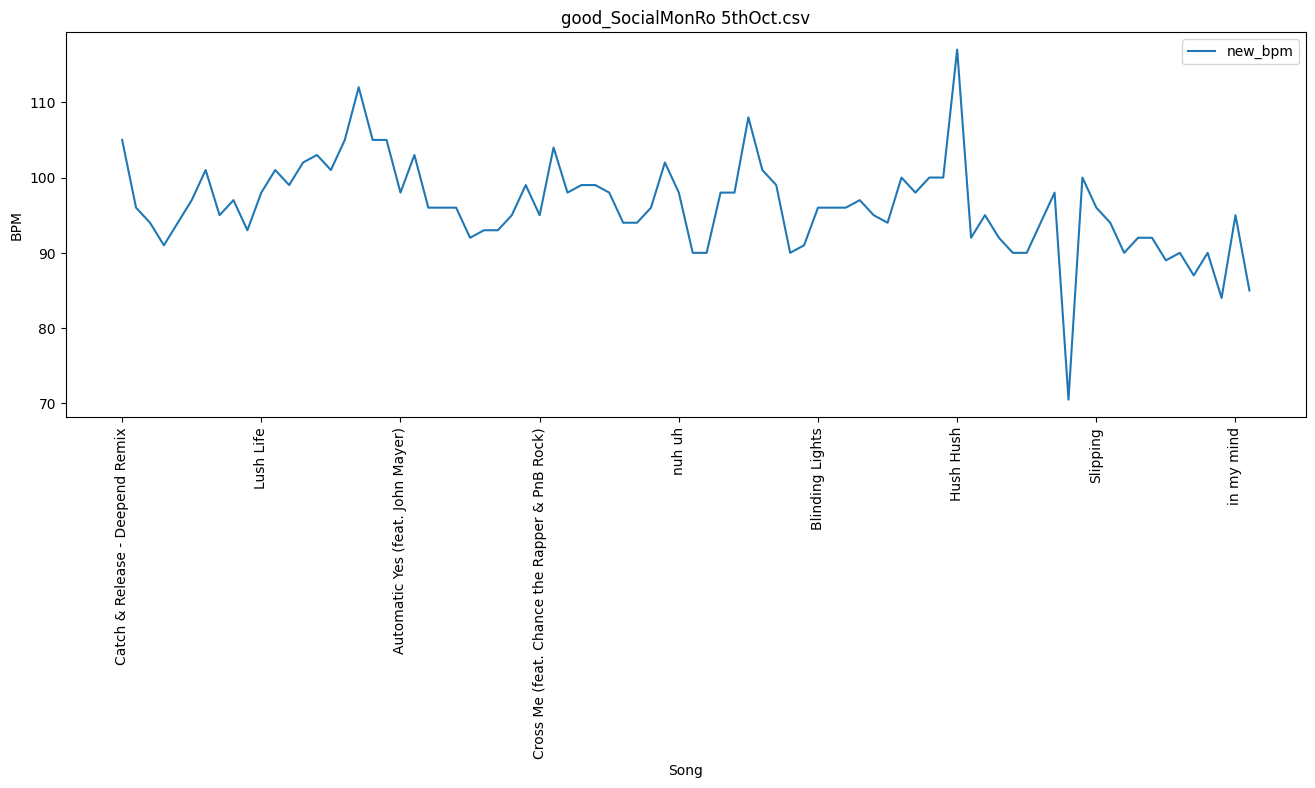

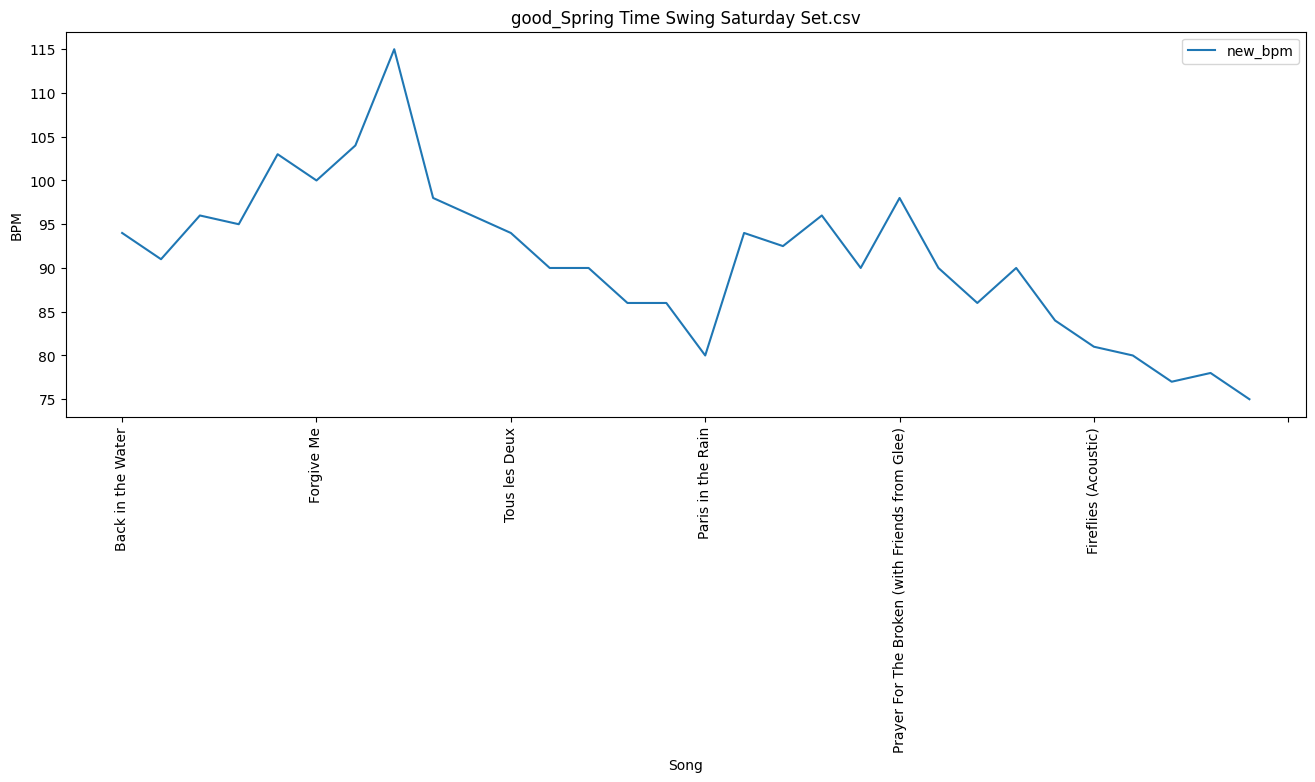

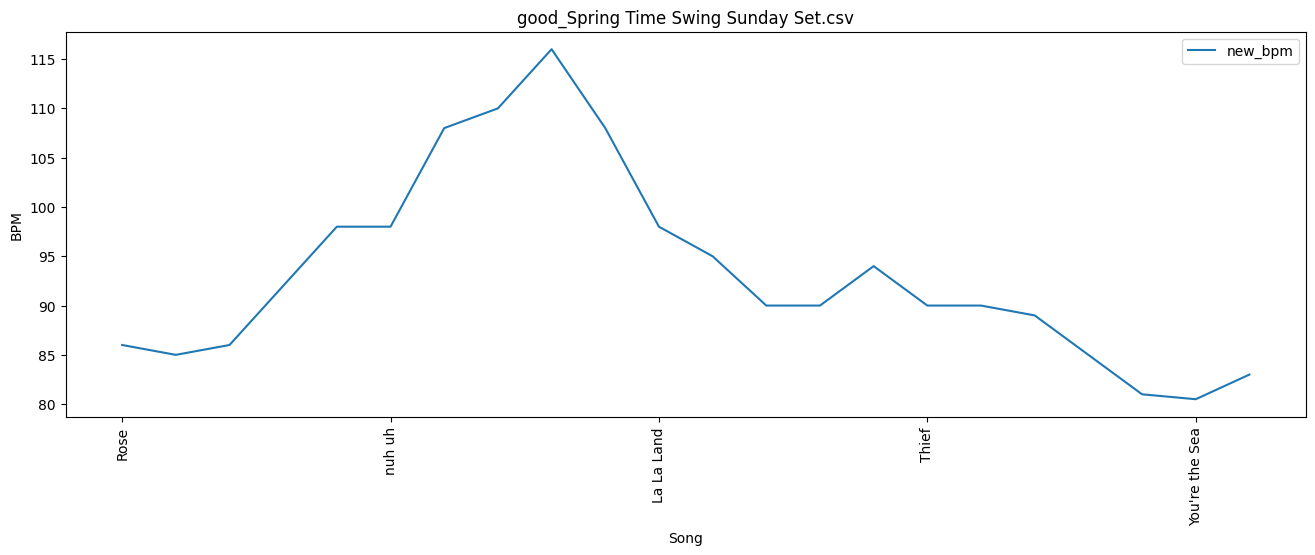

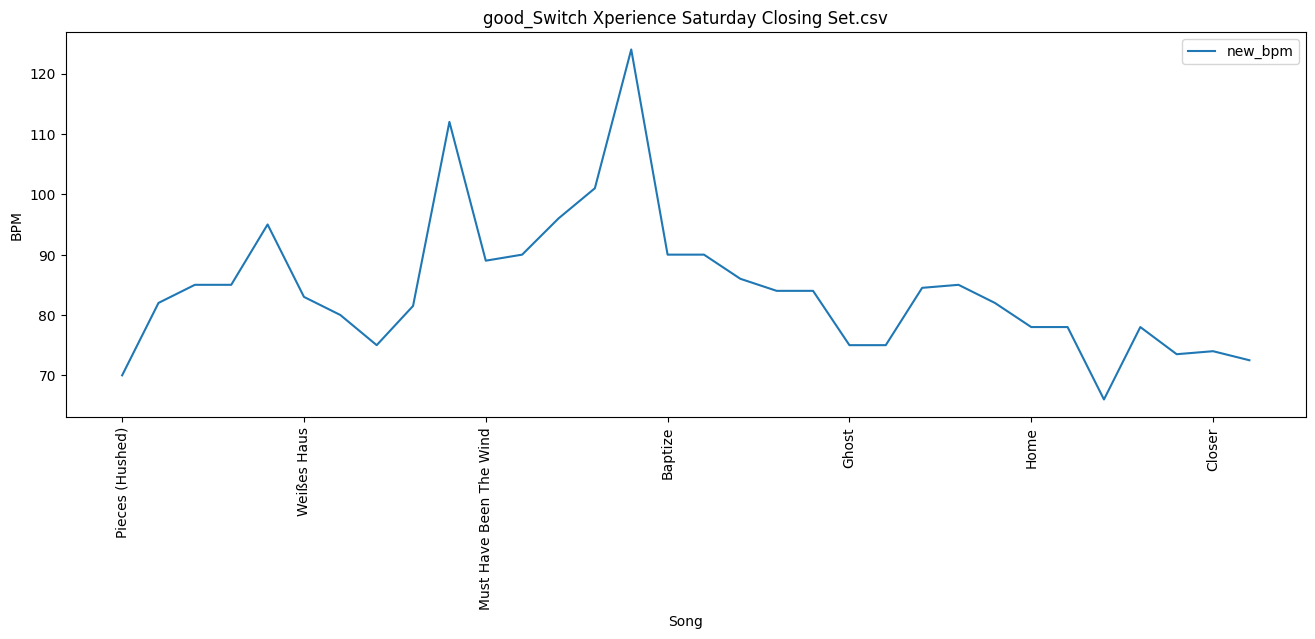

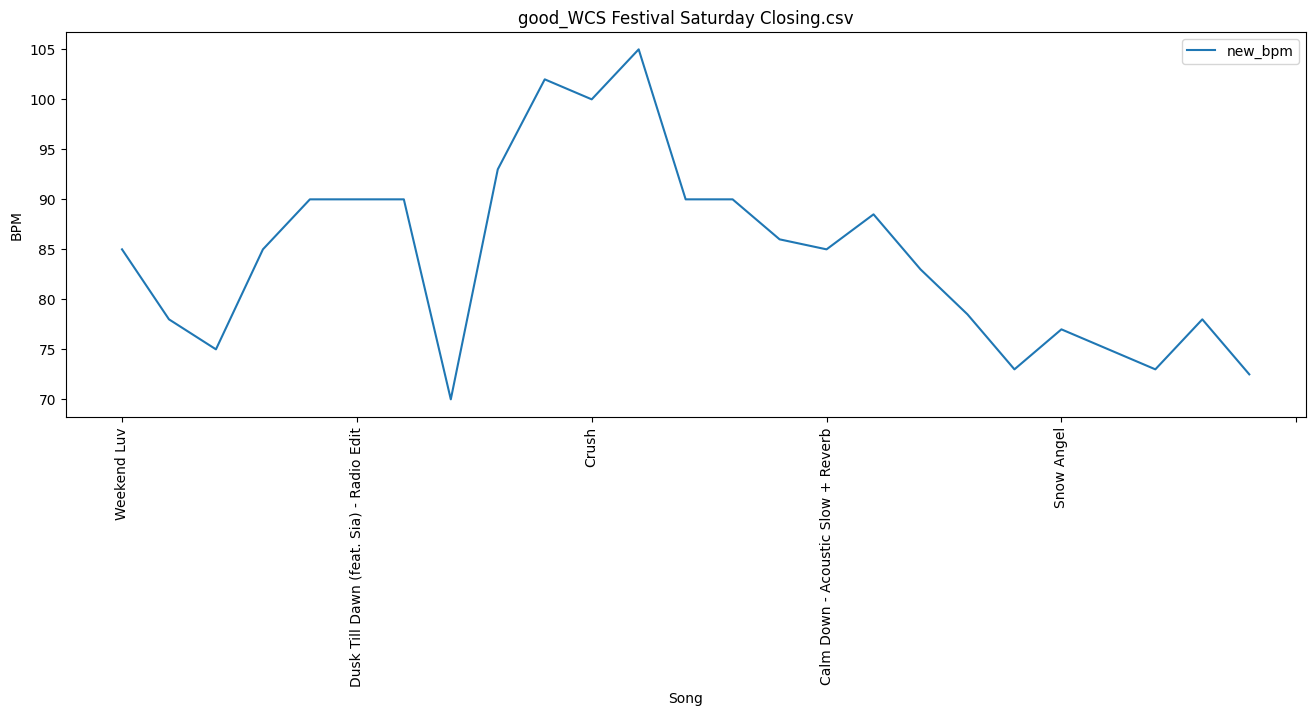

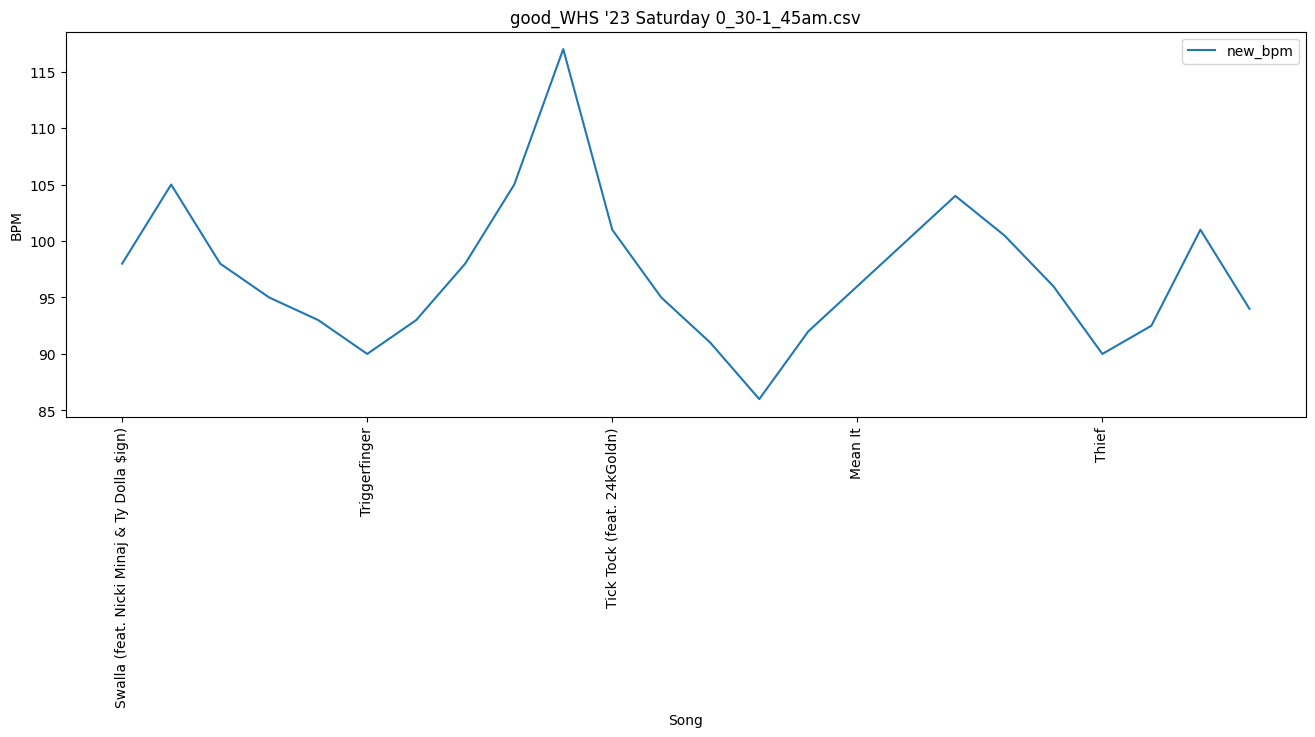

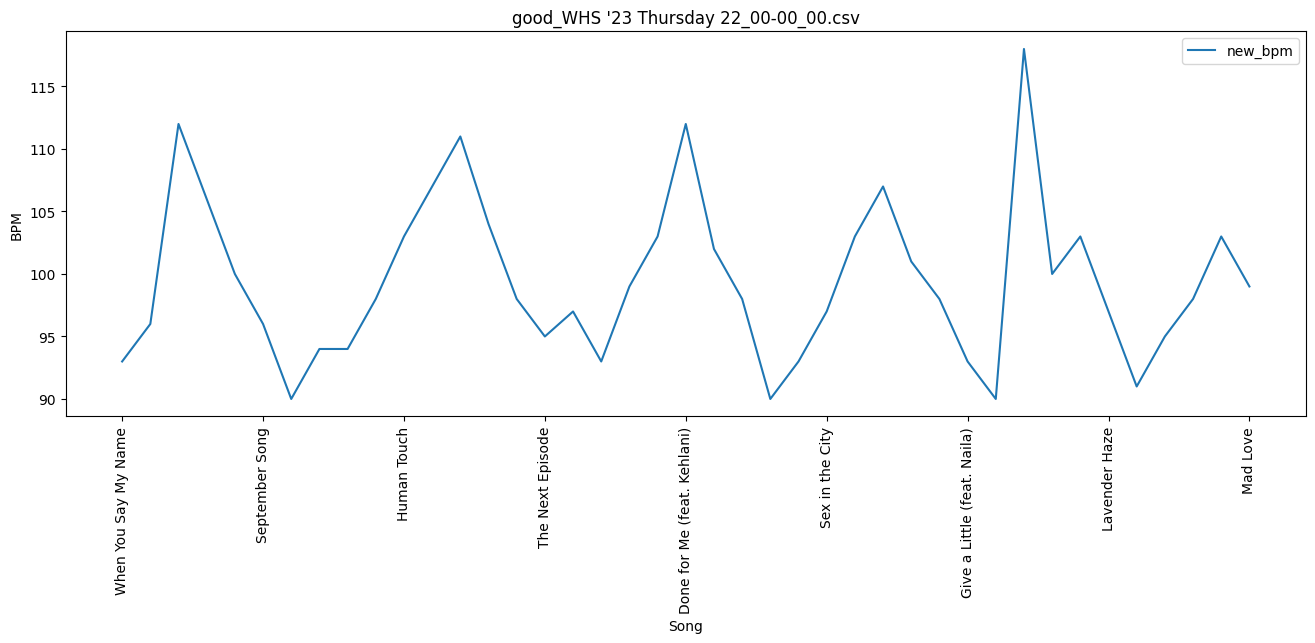

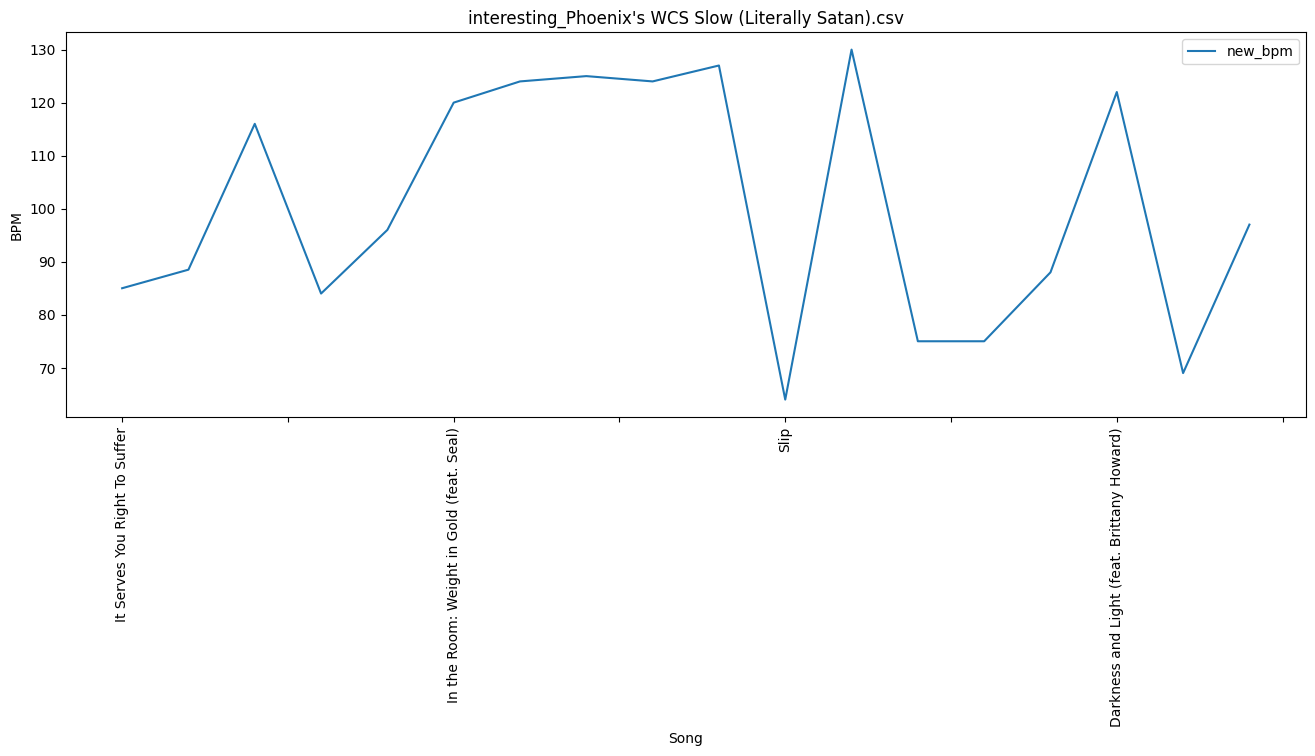

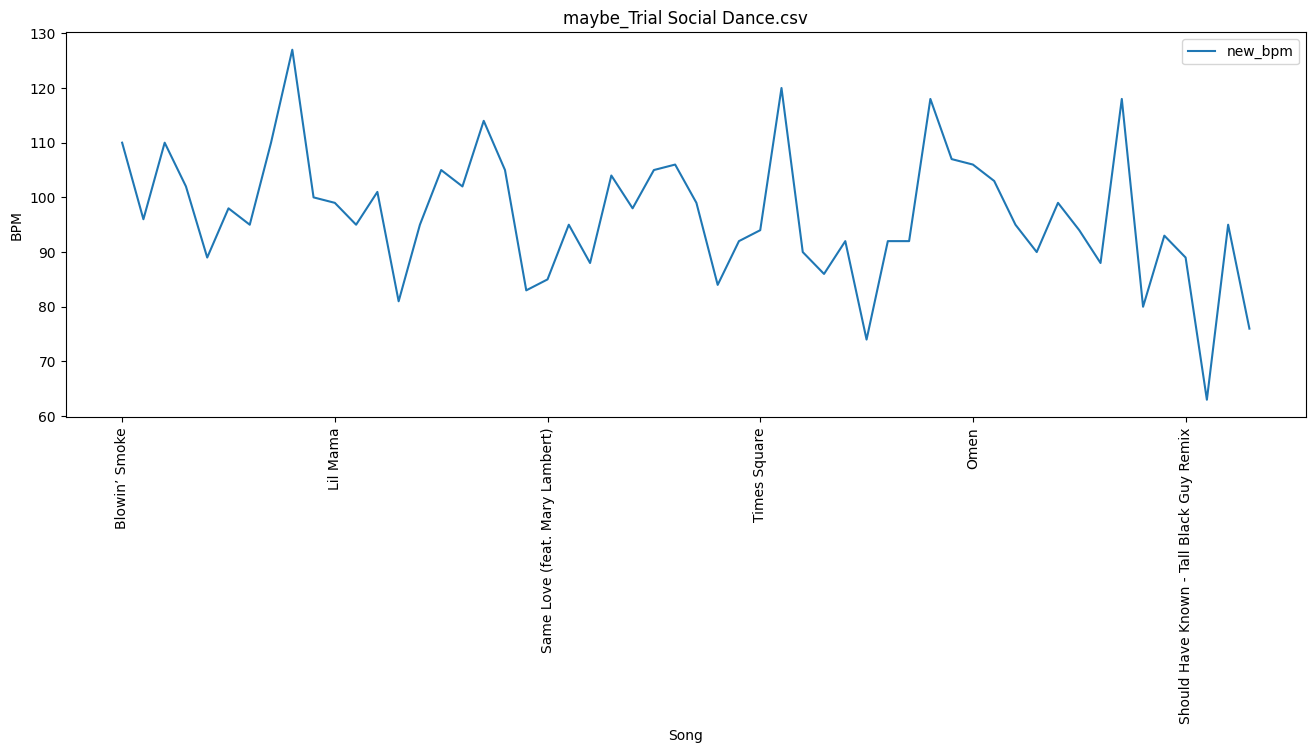

In [97]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        (pl.read_csv(f'Playlists/{i}')
         .with_columns(
             #correctifies the worst of Spotify's bpm attempts
             new_bpm = pl.when(pl.col('BPM') >= 135)
                        .then(pl.col('BPM')/2)
                        .when(pl.col('BPM') <= 50)
                        .then(pl.col('BPM')*2)
                        .otherwise(pl.col('BPM')),
             #truncates loooong song names so they don't kill graph proportions
             song = pl.col('Song').str.slice(0,18),
         )
        .to_pandas()
        #plot things
        ).plot(x='Song', 
               y='new_bpm', 
               kind='line',
               title=i,
               figsize=(16, 5), 
               legend=True, 
               rot=90, 
               ylabel='BPM',
              )

### Observations

With Spotify's bpm inaccuracy, you can actually see how clear/simple the beats are in some of the sets. If there's a lot of variation or jumps, it likely means the songs have some complex rhythms that are confusing Spotify. Some playlists above show a clear `/\/\/\/\/\` which might be a good indicator that the beats are clear enough to dance to for beginners!



### Graphing with `hvplot`

In [ ]:
for i in sorted(os.listdir('Playlists/')):
    if 'unordered' not in i and '.csv' in i:
        display(pl.read_csv(f'Playlists/{i}').pipe(adjust_bpm)
                 
                #plot things
                .hvplot(x='song', 
                         y=['new_bpm',  
                            # 'Energy'
                           ], 
                         width=1300, 
                         height=500, 
                         stacked=True,
                         legend='top', 
                         title=i,
                        ).opts(xrotation=90)) #rotating song names

## Prepping the data for analysis

This is where we're gonna go from 0-100 real quick. I'm doing a lot of modifications - with comments - to prep our dataset for things we'll want to do later. This involves:
* Adding playlist names
* Correctify Spotify bpm blunders
* Truncate long song names
* Show where a song is in each playlist

In [88]:
# !pip install polars hvplot altair --upgrade
import polars as pl
import hvplot.polars
import os
import matplotlib as plt
import altair

dfs = []

for _ in sorted(os.listdir('Playlists/')):
    if '.csv' in _:
        df_ = pl.read_csv(f'Playlists/{_}')
        dfs.append(
            df_
             .pipe(adjust_bpm)
             .with_columns(
                 
                 #correctifies the worst of Spotify's bpm attempts
                 new_bpm = pl.when(pl.col('BPM') >= 135)
                            .then(pl.col('BPM')/2)
                            .when(pl.col('BPM') <= 50)
                            .then(pl.col('BPM')*2)
                            .otherwise(pl.col('BPM')),

                 #truncates loooong song names so they don't kill graph proportions
                 song = pl.col('Song').str.slice(0,18),

                 #set the playlist name
                 playlist = pl.lit(_),

                 #where the song is positioned in the playlist
                 song_position_in_playlist = pl.concat_str([pl.col('#'), pl.lit('/'), df_.shape[0]]),
                 
                 #where the song is positioned - beginning/middle/end
                 apprx_song_position_in_playlist = pl.when((pl.col('#')*100 / pl.lit(df_.shape[0])) <= 33)
                                                      .then(pl.lit('beginning'))
                                                      .when((pl.col('#')*100 / pl.lit(df_.shape[0])) >= 34,
                                                            (pl.col('#')*100 / pl.lit(df_.shape[0])) <= 66)
                                                      .then(pl.lit('middle'))
                                                      .when((pl.col('#')*100 / pl.lit(df_.shape[0])) >= 67)
                                                      .then(pl.lit('end'))
              )

             #prevents the numbers from being summed when they shouldn't be
             .select(pl.all().cast(pl.String))
            )

df = pl.concat(dfs)
df

shape: (1_787, 30)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ #   ‚îÜ Song       ‚îÜ Artist     ‚îÜ Popularity ‚îÜ ‚Ä¶ ‚îÜ song       ‚îÜ playlist   ‚îÜ song_posi ‚îÜ apprx_son ‚îÇ
‚îÇ --- ‚îÜ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---        ‚îÜ tion_in_p ‚îÜ g_positio ‚îÇ
‚îÇ str ‚îÜ str        ‚îÜ str        ‚îÜ str        ‚îÜ   ‚îÜ str        ‚îÜ str        ‚îÜ laylist   ‚îÜ n_in_play ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ ---       ‚îÜ lis‚Ä¶      ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ str       ‚îÜ ---       ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ            ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1   ‚îÜ Sweet      ‚îÜ Sons Of    ‚îÜ 6          ‚îÜ ‚Ä¶ ‚îÜ Sweet      ‚îÜ beginner_D ‚îÜ 1/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ Madness    ‚îÜ Maria,Ange ‚îÜ            ‚îÜ   ‚îÜ Madness    ‚îÜ J1_Stuggi  ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ lika Vee   ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ Outdoor    ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ 20‚Ä¶        ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 2   ‚îÜ Not Going  ‚îÜ DVBBS,CMC$ ‚îÜ 46         ‚îÜ ‚Ä¶ ‚îÜ Not Going  ‚îÜ beginner_D ‚îÜ 2/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ Home       ‚îÜ ,Gia Koka  ‚îÜ            ‚îÜ   ‚îÜ Home (fe   ‚îÜ J1_Stuggi  ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ (feat. Gia ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ Outdoor    ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ Koka‚Ä¶      ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ 20‚Ä¶        ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 3   ‚îÜ 2step      ‚îÜ Ed Sheeran ‚îÜ 6          ‚îÜ ‚Ä¶ ‚îÜ 2step      ‚îÜ beginner_D ‚îÜ 3/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ ,Lil Baby  ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ J1_Stuggi  ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ Outdoor    ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ 20‚Ä¶        ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 4   ‚îÜ AFU        ‚îÜ CAL        ‚îÜ 30         ‚îÜ ‚Ä¶ ‚îÜ AFU        ‚îÜ beginner_D ‚îÜ 4/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ J1_Stuggi  ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ Outdoor    ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ 20‚Ä¶        ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 5   ‚îÜ Je ne      ‚îÜ Namika     ‚îÜ 51         ‚îÜ ‚Ä¶ ‚îÜ Je ne      ‚îÜ beginner_D ‚îÜ 5/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ parle pas  ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ parle pas  ‚îÜ J1_Stuggi  ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ fran√ßais   ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ fr         ‚îÜ Outdoor    ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ 20‚Ä¶        ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 6   ‚îÜ Ghost Boy  ‚îÜ Jacob      ‚îÜ 44         ‚îÜ ‚Ä¶ ‚îÜ Ghost Boy  ‚îÜ beginner_D ‚îÜ 6/55      ‚îÜ beginning ‚îÇ
‚îÇ     ‚îÜ            ‚îÜ Tillberg   ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ J1_St

## What music is (un)common in my bubble?

In [ ]:
#tbd

### What're the most and least common songs?

In [110]:
(df
 .group_by('Artist', 'Song')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

shape: (1_359, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Artist       ‚îÜ Song        ‚îÜ #           ‚îÜ song_positi ‚îÜ apprx_song_ ‚îÜ playlist    ‚îÜ num_playlis ‚îÇ
‚îÇ ---          ‚îÜ ---         ‚îÜ ---         ‚îÜ on_in_playl ‚îÜ position_in ‚îÜ ---         ‚îÜ ts          ‚îÇ
‚îÇ str          ‚îÜ str         ‚îÜ list[str]   ‚îÜ ist         ‚îÜ _playlis‚Ä¶   ‚îÜ list[str]   ‚îÜ ---         ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ ---         ‚îÜ ---         ‚îÜ             ‚îÜ u32         ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ list[str]   ‚îÜ list[str]   ‚îÜ             ‚îÜ             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Oh Wonder    ‚îÜ Lonely Star ‚îÜ ["140",     ‚îÜ ["140/149", ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "15", ‚îÜ "15/25",    ‚îÜ ", "end",   ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "22"‚Ä¶ ‚îÜ "15/25", ‚Ä¶  ‚îÜ "end", "e‚Ä¶  ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ SYML         ‚îÜ Fear of the ‚îÜ ["13",      ‚îÜ ["13/37",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ Water       ‚îÜ "141",      ‚îÜ "141/149",  ‚îÜ ", "end",   ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "25", "28", ‚îÜ "25/25", ‚Ä¶  ‚îÜ "end", "e‚Ä¶  ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "46"‚Ä¶       ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Neon Dreams  ‚îÜ Times       ‚îÜ ["11",      ‚îÜ ["11/25",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ Square      ‚îÜ "17", "29", ‚îÜ "17/30",    ‚îÜ ", "beginni ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "3", "31",  ‚îÜ "29/37",    ‚îÜ ng", "en‚Ä¶   ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ ‚Ä¶           ‚îÜ "3‚Ä¶         ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Nick         ‚îÜ Little      ‚îÜ ["12",      ‚îÜ ["12/32",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ Broadhurst   ‚îÜ Lover       ‚îÜ "13", "22", ‚îÜ "13/25",    ‚îÜ ", "end",   ‚îÜ .06.07      ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "25",       ‚îÜ "22/30",    ‚îÜ "end", "m‚Ä¶  ‚îÜ Baltic      ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "26",‚Ä¶      ‚îÜ "2‚Ä¶         ‚îÜ             ‚îÜ Swing‚Ä¶      ‚îÜ             ‚îÇ
‚îÇ Emeli Sand√©  ‚îÜ Oxygen      ‚îÜ ["136",     ‚îÜ ["136/149", ‚îÜ ["end",     ‚îÜ ["beginner_ ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "17", ‚îÜ "15/30",    ‚îÜ "end",      ‚îÜ DJ2_Swing   ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "18", "35"‚Ä¶ ‚îÜ "17/25", ‚Ä¶  ‚îÜ "end",      ‚îÜ Amore 202‚Ä¶  ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ "end", "‚Ä¶   ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Jades        ‚îÜ nuh uh      ‚îÜ ["2", "39", ‚îÜ ["2/37",    ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ Goudreault   ‚îÜ             ‚îÜ "41", "41", ‚îÜ "39/41",    ‚îÜ ", "beginni ‚îÜ .06.28 Libe ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "6", "‚Ä¶     ‚îÜ "41/42",    ‚îÜ ng", "be‚Ä¶   ‚îÜ rty.csv"‚Ä¶   ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ "41‚Ä¶        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Ruben        ‚îÜ The Half    ‚îÜ ["16",      ‚îÜ 

### Which Artists are most played among everyone?

In [111]:
pl.Config.set_fmt_table_cell_list_len(15)

(df
 .group_by('Artist')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

shape: (1_042, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Artist         ‚îÜ #              ‚îÜ song_position_ ‚îÜ apprx_song_po ‚îÜ playlist      ‚îÜ num_playlists ‚îÇ
‚îÇ ---            ‚îÜ ---            ‚îÜ in_playlist    ‚îÜ sition_in_pla ‚îÜ ---           ‚îÜ ---           ‚îÇ
‚îÇ str            ‚îÜ list[str]      ‚îÜ ---            ‚îÜ ylis‚Ä¶         ‚îÜ list[str]     ‚îÜ u32           ‚îÇ
‚îÇ                ‚îÜ                ‚îÜ list[str]      ‚îÜ ---           ‚îÜ               ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ                ‚îÜ                ‚îÜ list[str]     ‚îÜ               ‚îÜ               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Ed Sheeran     ‚îÜ ["11", "12",   ‚îÜ ["11/28",      ‚îÜ [null,        ‚îÜ ["beginner_DJ ‚îÜ 12            ‚îÇ
‚îÇ                ‚îÜ "13", "142",   ‚îÜ "12/24",       ‚îÜ "beginning",  ‚îÜ 2_Swing Amore ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "15"‚Ä¶          ‚îÜ "13/74", "1‚Ä¶   ‚îÜ "beginning‚Ä¶   ‚îÜ 202‚Ä¶          ‚îÜ               ‚îÇ
‚îÇ HAEVN          ‚îÜ ["1", "10",    ‚îÜ ["1/30",       ‚îÜ ["beginning", ‚îÜ ["good_2024.0 ‚îÜ 11            ‚îÇ
‚îÇ                ‚îÜ "14", "15",    ‚îÜ "10/115",      ‚îÜ "beginning",  ‚îÜ 4.20 Asia     ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "17", ‚Ä¶        ‚îÜ "14/56", "1‚Ä¶   ‚îÜ "be‚Ä¶          ‚îÜ Open.cs‚Ä¶      ‚îÜ               ‚îÇ
‚îÇ SYML           ‚îÜ ["13", "13",   ‚îÜ ["13/32",      ‚îÜ ["beginning", ‚îÜ ["good_2024.0 ‚îÜ 10            ‚îÇ
‚îÇ                ‚îÜ "141", "18",   ‚îÜ "13/37",       ‚îÜ "end", "end", ‚îÜ 4.20 Asia     ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "25"‚Ä¶          ‚îÜ "141/149", ‚Ä¶   ‚îÜ "e‚Ä¶           ‚îÜ Open.cs‚Ä¶      ‚îÜ               ‚îÇ
‚îÇ Billie Eilish  ‚îÜ ["102", "13",  ‚îÜ ["102/149",    ‚îÜ ["beginning", ‚îÜ ["good_2021-0 ‚îÜ 10            ‚îÇ
‚îÇ                ‚îÜ "15", "15",    ‚îÜ "13/70",       ‚îÜ "beginning",  ‚îÜ 8-07 1st      ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "17"‚Ä¶          ‚îÜ "15/115",‚Ä¶     ‚îÜ "be‚Ä¶          ‚îÜ Saturday‚Ä¶     ‚îÜ               ‚îÇ
‚îÇ Elderbrook     ‚îÜ ["10", "10",   ‚îÜ ["10/19",      ‚îÜ ["beginning", ‚îÜ ["beginner_DJ ‚îÜ 10            ‚îÇ
‚îÇ                ‚îÜ "12", "14",    ‚îÜ "10/48",       ‚îÜ "beginning",  ‚îÜ 3_Swing Amore ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "18",‚Ä¶         ‚îÜ "12/25", "1‚Ä¶   ‚îÜ "be‚Ä¶          ‚îÜ 202‚Ä¶          ‚îÜ               ‚îÇ
‚îÇ Glass Animals  ‚îÜ ["131", "190", ‚îÜ ["131/216",    ‚îÜ ["beginning", ‚îÜ ["beginner_DJ ‚îÜ 9             ‚îÇ
‚îÇ                ‚îÜ "2", "20",     ‚îÜ "190/216",     ‚îÜ "end", "end", ‚îÜ 1_Stuggi      ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "23"‚Ä¶          ‚îÜ "2/42",‚Ä¶       ‚îÜ "e‚Ä¶           ‚îÜ Outdoor ‚Ä¶     ‚îÜ               ‚îÇ
‚îÇ Lauv           ‚îÜ ["16", "25",   ‚îÜ ["16/30",      ‚îÜ ["beginning", ‚îÜ ["beginner_DJ ‚îÜ 9             ‚îÇ
‚îÇ                ‚îÜ "26", "27",    ‚îÜ "25/37",       ‚îÜ "beginning",  ‚îÜ 2_Swing Amore ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "38",‚Ä¶         ‚îÜ "26/82", "2‚Ä¶   ‚îÜ "en‚Ä¶          ‚îÜ 202‚Ä¶          ‚îÜ               ‚îÇ
‚îÇ Ruben          ‚îÜ ["16", "16",   ‚îÜ ["16/216",     ‚îÜ ["beginning", ‚îÜ ["good_2024.0 ‚îÜ 9             ‚îÇ
‚îÇ                ‚îÜ "17", "17",    ‚îÜ "16/25",       ‚îÜ "beginning",  ‚îÜ 4.20 Asia     ‚îÜ               ‚îÇ
‚îÇ                ‚îÜ "19",‚Ä¶         ‚îÜ "17/22", "‚Ä¶    ‚îÜ "be‚Ä¶          ‚îÜ Open.cs‚Ä¶      ‚

### Where are songs in playlists?


In [112]:
pl.Config.set_tbl_rows(50)
(df
 .group_by('Artist', 'Song')
 .agg(pl.col('#', 'song_position_in_playlist', 'apprx_song_position_in_playlist', 'playlist').sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
 # .filter(pl.col('apprx_song_position_in_playlist').list.join(',').str.contains('middle'))
)

shape: (1_359, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Artist       ‚îÜ Song        ‚îÜ #           ‚îÜ song_positi ‚îÜ apprx_song_ ‚îÜ playlist    ‚îÜ num_playlis ‚îÇ
‚îÇ ---          ‚îÜ ---         ‚îÜ ---         ‚îÜ on_in_playl ‚îÜ position_in ‚îÜ ---         ‚îÜ ts          ‚îÇ
‚îÇ str          ‚îÜ str         ‚îÜ list[str]   ‚îÜ ist         ‚îÜ _playlis‚Ä¶   ‚îÜ list[str]   ‚îÜ ---         ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ ---         ‚îÜ ---         ‚îÜ             ‚îÜ u32         ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ list[str]   ‚îÜ list[str]   ‚îÜ             ‚îÜ             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Oh Wonder    ‚îÜ Lonely Star ‚îÜ ["140",     ‚îÜ ["140/149", ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "15", ‚îÜ "15/25",    ‚îÜ ", "end",   ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "22"‚Ä¶ ‚îÜ "15/25", ‚Ä¶  ‚îÜ "end", "e‚Ä¶  ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ Emeli Sand√©  ‚îÜ Oxygen      ‚îÜ ["136",     ‚îÜ ["136/149", ‚îÜ ["end",     ‚îÜ ["beginner_ ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "15", "17", ‚îÜ "15/30",    ‚îÜ "end",      ‚îÜ DJ2_Swing   ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "18", "35"‚Ä¶ ‚îÜ "17/25", ‚Ä¶  ‚îÜ "end",      ‚îÜ Amore 202‚Ä¶  ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ "end", "‚Ä¶   ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Neon Dreams  ‚îÜ Times       ‚îÜ ["11",      ‚îÜ ["11/25",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ Square      ‚îÜ "17", "29", ‚îÜ "17/30",    ‚îÜ ", "beginni ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "3", "31",  ‚îÜ "29/37",    ‚îÜ ng", "en‚Ä¶   ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ ‚Ä¶           ‚îÜ "3‚Ä¶         ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Jades        ‚îÜ nuh uh      ‚îÜ ["2", "39", ‚îÜ ["2/37",    ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ Goudreault   ‚îÜ             ‚îÜ "41", "41", ‚îÜ "39/41",    ‚îÜ ", "beginni ‚îÜ .06.28 Libe ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "6", "‚Ä¶     ‚îÜ "41/42",    ‚îÜ ng", "be‚Ä¶   ‚îÜ rty.csv"‚Ä¶   ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ             ‚îÜ "41‚Ä¶        ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Nick         ‚îÜ Little      ‚îÜ ["12",      ‚îÜ ["12/32",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ Broadhurst   ‚îÜ Lover       ‚îÜ "13", "22", ‚îÜ "13/25",    ‚îÜ ", "end",   ‚îÜ .06.07      ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "25",       ‚îÜ "22/30",    ‚îÜ "end", "m‚Ä¶  ‚îÜ Baltic      ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "26",‚Ä¶      ‚îÜ "2‚Ä¶         ‚îÜ             ‚îÜ Swing‚Ä¶      ‚îÜ             ‚îÇ
‚îÇ SYML         ‚îÜ Fear of the ‚îÜ ["13",      ‚îÜ ["13/37",   ‚îÜ ["beginning ‚îÜ ["good_2024 ‚îÜ 7           ‚îÇ
‚îÇ              ‚îÜ Water       ‚îÜ "141",      ‚îÜ "141/149",  ‚îÜ ", "end",   ‚îÜ .04.20 Asia ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "25", "28", ‚îÜ "25/25", ‚Ä¶  ‚îÜ "end", "e‚Ä¶  ‚îÜ Open.cs‚Ä¶    ‚îÜ             ‚îÇ
‚îÇ              ‚îÜ             ‚îÜ "46"‚Ä¶       ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ             ‚îÇ
‚îÇ Ruben        ‚îÜ The Half    ‚îÜ ["16",      ‚îÜ 

### What Artists are most played among my country?

In [ ]:
# (pl.concat(dfs)
#  # .select(pl.all().cast(pl.String))
#  .group_by('Artist')
#  .agg(pl.col('Country').unique().sort(),
#       pl.col('playlist').unique().sort(),
#       pl.col('Song')
#      )
#  .with_columns(num_playlists = pl.col('playlist').list.len())
#  .sort('num_playlists', descending = True)
# )

### What's the most common time signature

In [113]:
(df
 .group_by('Time Signature')
 .agg(pl.all().unique().sort())
 .with_columns(pl.col('playlist').list.unique().list.sort(),
               num_playlists = pl.col('playlist').list.unique().list.len())
 .sort('num_playlists', descending = True)
)

shape: (4, 31)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Time      ‚îÜ #         ‚îÜ Song      ‚îÜ Artist    ‚îÜ ‚Ä¶ ‚îÜ playlist  ‚îÜ song_posi ‚îÜ apprx_son ‚îÜ num_play ‚îÇ
‚îÇ Signature ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ tion_in_p ‚îÜ g_positio ‚îÜ lists    ‚îÇ
‚îÇ ---       ‚îÜ list[str] ‚îÜ list[str] ‚îÜ list[str] ‚îÜ   ‚îÜ list[str] ‚îÜ laylist   ‚îÜ n_in_play ‚îÜ ---      ‚îÇ
‚îÇ str       ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ ---       ‚îÜ lis‚Ä¶      ‚îÜ u32      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ list[str] ‚îÜ ---       ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ list[str] ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 4         ‚îÜ ["1",     ‚îÜ ["(Sittin ‚îÜ ["*NSYNC, ‚îÜ ‚Ä¶ ‚îÜ ["beginne ‚îÜ ["1/10",  ‚îÜ [null,    ‚îÜ 37       ‚îÇ
‚îÇ           ‚îÜ "10",     ‚îÜ ' On) the ‚îÜ Justin    ‚îÜ   ‚îÜ r_DJ1_Stu ‚îÜ "1/115",  ‚îÜ "beginnin ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "100",    ‚îÜ Dock of   ‚îÜ Timberlak ‚îÜ   ‚îÜ ggi       ‚îÜ "1/12",   ‚îÜ g",       ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "101",    ‚îÜ the‚Ä¶      ‚îÜ e", "‚Ä¶    ‚îÜ   ‚îÜ Outdoor ‚Ä¶ ‚îÜ "1/1‚Ä¶     ‚îÜ "end",    ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "102‚Ä¶     ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ "mi‚Ä¶      ‚îÜ          ‚îÇ
‚îÇ 3         ‚îÜ ["1",     ‚îÜ ["ALL     ‚îÜ ["Anne-Ma ‚îÜ ‚Ä¶ ‚îÜ ["beginne ‚îÜ ["1/12",  ‚îÜ ["beginni ‚îÜ 24       ‚îÇ
‚îÇ           ‚îÜ "10",     ‚îÜ IN",      ‚îÜ rie",     ‚îÜ   ‚îÜ r_DJ1_Stu ‚îÜ "1/18",   ‚îÜ ng",      ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "104",    ‚îÜ "Aliens   ‚îÜ "Aretha   ‚îÜ   ‚îÜ ggi       ‚îÜ "10/32",  ‚îÜ "end",    ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "108",    ‚îÜ Need Love ‚îÜ Frankli‚Ä¶  ‚îÜ   ‚îÜ Outdoor ‚Ä¶ ‚îÜ "104‚Ä¶     ‚îÜ "middle"] ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "109‚Ä¶     ‚îÜ T‚Ä¶        ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 1         ‚îÜ ["1",     ‚îÜ ["A       ‚îÜ ["Ashnikk ‚îÜ ‚Ä¶ ‚îÜ ["beginne ‚îÜ ["1/25",  ‚îÜ ["beginni ‚îÜ 13       ‚îÇ
‚îÇ           ‚îÜ "12",     ‚îÜ Prayer",  ‚îÜ o",       ‚îÜ   ‚îÜ r_DJ3_Swi ‚îÜ "12/19",  ‚îÜ ng",      ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "13",     ‚îÜ "Cola -   ‚îÜ "Bakar",  ‚îÜ   ‚îÜ ng Amore  ‚îÜ "13/22",  ‚îÜ "end",    ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "178",    ‚îÜ Elderbroo ‚îÜ "CamelPh‚Ä¶ ‚îÜ   ‚îÜ 202‚Ä¶      ‚îÜ "13‚Ä¶      ‚îÜ "middle"] ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "2", ‚Ä¶    ‚îÜ ‚Ä¶         ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ 5         ‚îÜ ["15",    ‚îÜ ["Afterta ‚îÜ ["JP      ‚îÜ ‚Ä¶ ‚îÜ ["beginne ‚îÜ ["15/18", ‚îÜ ["end",   ‚îÜ 7        ‚îÇ
‚îÇ           ‚îÜ "211",    ‚îÜ ste       ‚îÜ Cooper",  ‚îÜ   ‚îÜ r_DJ3_Swi ‚îÜ "211/216" ‚îÜ "middle"] ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "25",     ‚îÜ (feat.    ‚îÜ "Libianca ‚îÜ   ‚îÜ ng Amore  ‚îÜ ,         ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "32",     ‚îÜ Opia)",   ‚îÜ ", "R. ‚Ä¶  ‚îÜ   ‚îÜ 202‚Ä¶      ‚îÜ "25/48",  ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ           ‚îÜ "33"‚Ä¶     ‚îÜ "B‚Ä¶       ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ ‚Ä¶         ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ